<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [7]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import kagglehub
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [8]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
image_size = 128
batch_size = 128
latent_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [9]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """

    # Download latest version
    path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

    print("Path to dataset files:", path)

    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose([
        tt.ToTensor(),
        tt.Resize(image_size),
        tt.Normalize(*stats)
    ])
    return DataLoader(ImageFolder(root=path, transform=transform), batch_size=batch_size)


In [10]:
#TODO: build dataloader and transfer it to device
data_loader = get_dataloader(image_size=image_size, batch_size=batch_size)


100%|█████████████████████████████████████████████████████████████████████████████| 3.99G/3.99G [06:20<00:00, 11.2MB/s]

Extracting files...


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\tommykamaz\faces-dataset-small\versions\1


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = discriminator.to(device)

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [14]:
generator = generator.to(device)

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [22]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [25]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(data_loader):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            real_images = real_images.to(device)

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 50

history = fit(model, criterion, epochs, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 9.1658, loss_d: 0.4670, real_score: 0.9616, fake_score: 0.1331


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 6.6036, loss_d: 0.6339, real_score: 0.8949, fake_score: 0.1222


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 6.4936, loss_d: 0.4753, real_score: 0.8937, fake_score: 0.1685


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 7.6845, loss_d: 0.1206, real_score: 0.9526, fake_score: 0.0427


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 7.6791, loss_d: 0.1975, real_score: 0.9292, fake_score: 0.0442


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 8.2129, loss_d: 0.0760, real_score: 0.9777, fake_score: 0.0412


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 9.4805, loss_d: 0.1519, real_score: 0.9538, fake_score: 0.0557


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.5267, loss_d: 0.0224, real_score: 0.9927, fake_score: 0.0136


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 6.8654, loss_d: 0.0227, real_score: 0.9944, fake_score: 0.0159


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 6.0514, loss_d: 0.0127, real_score: 0.9972, fake_score: 0.0097


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.8542, loss_d: 0.6544, real_score: 0.9010, fake_score: 0.0933


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 7.5332, loss_d: 0.0814, real_score: 0.9736, fake_score: 0.0442


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 9.5986, loss_d: 0.6818, real_score: 0.8610, fake_score: 0.1181


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 7.9001, loss_d: 0.4915, real_score: 0.8783, fake_score: 0.1268


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.9851, loss_d: 1.0458, real_score: 0.7769, fake_score: 0.1934


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.5156, loss_d: 0.9932, real_score: 0.7421, fake_score: 0.2755


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.0795, loss_d: 0.9301, real_score: 0.6803, fake_score: 0.2660


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.0278, loss_d: 0.9123, real_score: 0.7227, fake_score: 0.2947


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.9891, loss_d: 0.8271, real_score: 0.7512, fake_score: 0.2375


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.2943, loss_d: 0.7681, real_score: 0.7683, fake_score: 0.2404


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.6272, loss_d: 0.9677, real_score: 0.7176, fake_score: 0.2958


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 3.4280, loss_d: 0.9587, real_score: 0.7105, fake_score: 0.2559


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.3853, loss_d: 0.8591, real_score: 0.7236, fake_score: 0.2719


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.1079, loss_d: 0.8773, real_score: 0.7250, fake_score: 0.2826


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.4637, loss_d: 0.8192, real_score: 0.7381, fake_score: 0.2717


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.7900, loss_d: 0.9638, real_score: 0.7089, fake_score: 0.2832


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.8896, loss_d: 0.8902, real_score: 0.7237, fake_score: 0.2808


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.3872, loss_d: 0.8479, real_score: 0.7209, fake_score: 0.2619


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.3920, loss_d: 0.8256, real_score: 0.7364, fake_score: 0.2695


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.1784, loss_d: 0.9053, real_score: 0.7150, fake_score: 0.2820


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.8806, loss_d: 0.8778, real_score: 0.7244, fake_score: 0.2819


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.4549, loss_d: 0.9654, real_score: 0.6931, fake_score: 0.3040


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.3033, loss_d: 1.0395, real_score: 0.6768, fake_score: 0.3189


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.5870, loss_d: 0.9922, real_score: 0.6846, fake_score: 0.3047


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.5251, loss_d: 0.9434, real_score: 0.7046, fake_score: 0.3028


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.4439, loss_d: 0.8698, real_score: 0.7172, fake_score: 0.2935


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.6088, loss_d: 0.8337, real_score: 0.7159, fake_score: 0.2724


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.8244, loss_d: 0.9756, real_score: 0.7057, fake_score: 0.3030


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.6919, loss_d: 0.8277, real_score: 0.7207, fake_score: 0.2641


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.8617, loss_d: 0.9049, real_score: 0.7327, fake_score: 0.2793


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.9463, loss_d: 0.8252, real_score: 0.7197, fake_score: 0.2717


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.8107, loss_d: 0.8907, real_score: 0.7118, fake_score: 0.2839


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.8975, loss_d: 0.8085, real_score: 0.7335, fake_score: 0.2671


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.9343, loss_d: 0.8008, real_score: 0.7419, fake_score: 0.2561


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.0975, loss_d: 0.8310, real_score: 0.7256, fake_score: 0.2565


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.3927, loss_d: 0.9032, real_score: 0.7309, fake_score: 0.2809


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.0912, loss_d: 0.7643, real_score: 0.7471, fake_score: 0.2508


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.2480, loss_d: 0.7266, real_score: 0.7568, fake_score: 0.2288


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.4885, loss_d: 0.6942, real_score: 0.7707, fake_score: 0.2447


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.9867, loss_d: 0.8547, real_score: 0.7293, fake_score: 0.2585
Saving generated-images-0050.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Ответ: примерно на 17 эпохе выходим на плато в обучении, также в идеале Score для реальных и сгенерированных картинок должен быть 0.5.
Для повышения качества можно попробовать усложнить архитектуру генератора.

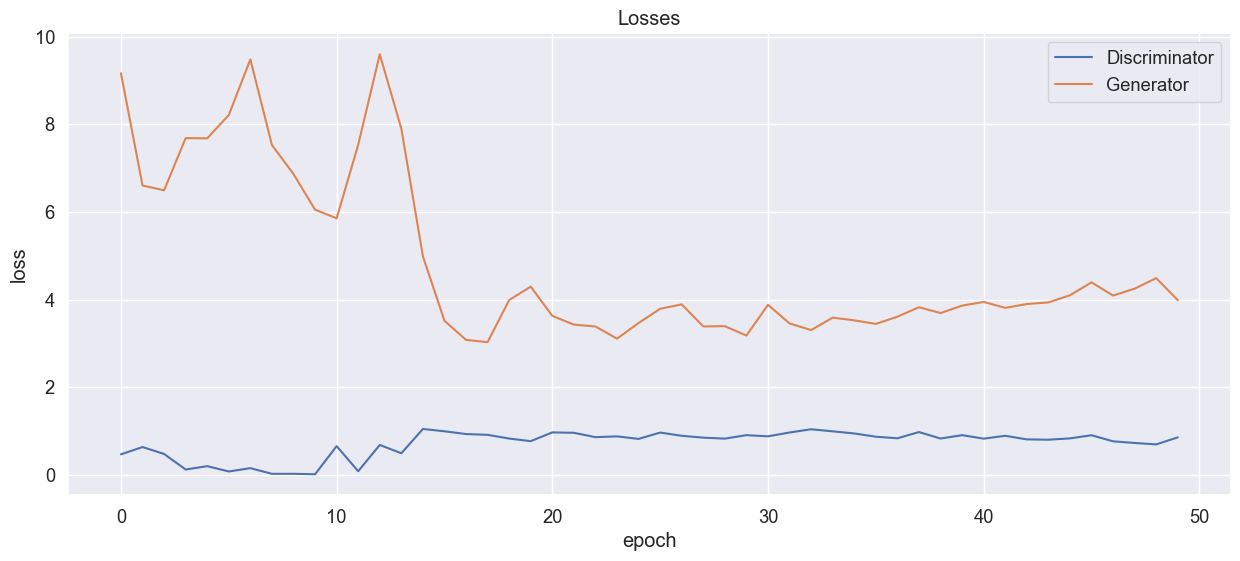

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

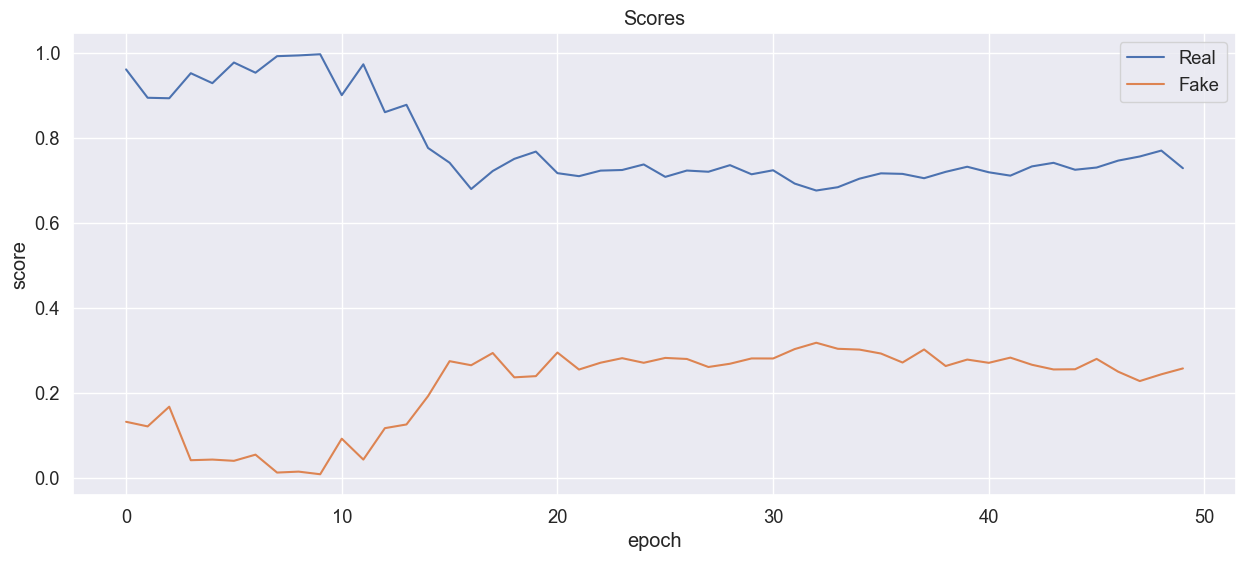

In [31]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [32]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [33]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

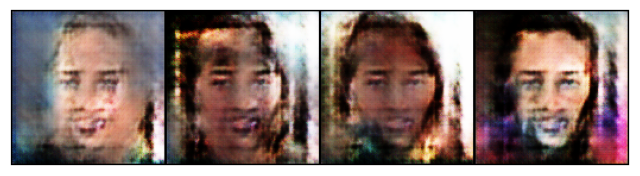

In [34]:
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

def evaluate_generated_images(real_images, fake_images):

    flat = nn.Flatten()
    real_images = flat(real_images).cpu().detach().numpy()
    fake_images = flat(fake_images).cpu().detach().numpy()
    y_real = np.ones(real_images.shape[0])
    y_fake = np.zeros(fake_images.shape[0])
    
    X = np.concatenate([real_images, fake_images], axis=0)
    y = np.concatenate([y_real, y_fake])

    knn = KNeighborsClassifier(n_neighbors=1)
    leave_one_out = LeaveOneOut()
    correct = 0

    for train_index, test_index in leave_one_out.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучаем классификатор
        knn.fit(X_train, y_train)

        # Проверяем качество на тестовом объекте
        y_pred = knn.predict(X_test)
        if y_pred == y_test:
            correct += 1
            
    accuracy = correct / len(X)
    return accuracy

In [36]:
real_images = []

counter = 0
for inputs, _ in data_loader:
    real_images.append(inputs)
    counter += 1
    if counter == 9:
        break
        
real_images = torch.cat(real_images, dim=0)[:10*batch_size].to(device)
latent = torch.randn(10 * batch_size, latent_size, 1, 1, device=device)
fake_images = model["generator"](latent)

# Обучаем и оцениваем качество классификатора
accuracy = evaluate_generated_images(real_images, fake_images)
print(f"Leave-One-Out Accuracy: {accuracy:.4f}")

C:\Program Files\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Program Files\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\Python310\lib\subprocess.py", line 969, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\Python310\lib\subprocess.py", line 1438, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Leave-One-Out Accuracy: 0.9572


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

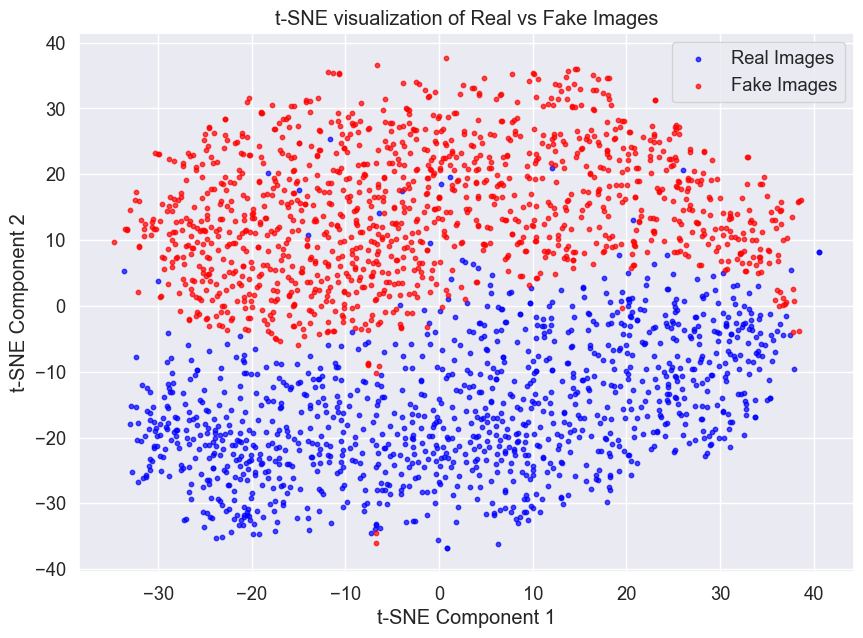

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

real_images = real_images.view(real_images.size(0), -1).cpu().detach().numpy()  # (batch_size, C * H * W)
fake_images = fake_images.view(fake_images.size(0), -1).cpu().detach().numpy()

all_images = np.concatenate([real_images, fake_images], axis=0)
labels = np.concatenate([
    np.ones(real_images.shape[0]),  # Метка 1 для реальных
    np.zeros(fake_images.shape[0]) # Метка 0 для фейковых
])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(all_images)

# Визуализация
plt.figure(figsize=(10, 7))
plt.scatter(
    reduced_data[labels == 1, 0], reduced_data[labels == 1, 1],
    label="Real Images", alpha=0.7, c='blue', s=10
)
plt.scatter(
    reduced_data[labels == 0, 0], reduced_data[labels == 0, 1],
    label="Fake Images", alpha=0.7, c='red', s=10
)
plt.legend()
plt.title("t-SNE visualization of Real vs Fake Images")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Прокомментируйте получившийся результат: по визуализации видим, что множества реальных и сгенерированных изображений не совпадают, что говорит о низком качестве сгенереированных изображений. Как и было сказано выше, возможным решением может быть улучшение архитектуры генератора.